In [13]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt

## 1 - Preparando a base

In [2]:
# seed para a reproducao
np.random.seed(42)

# numero de linhas do dataframe
n = 1000

# Teremos duas variaveis confundidoras quantitativas
X1 = np.random.normal(loc=0, scale=1, size=n)
X2 = np.random.normal(loc=5, scale=2, size=n)

# Uma variavel confundidora qualitativa, de duas categorias: A e B
X3 = np.random.choice(['A', 'B'], size=n)

# Para fins da criacao da base, a categoria B terá valor 1 
X3_numeric = np.where(X3 == 'B', 1, 0)

# Gerando o tratamento binario (0 e 1)
T = np.random.binomial(1, 0.5, n)

# Colocando algum ruído para simular a variabilidade de dados reais
noise = np.random.normal(0, 3, n)

# O outcome Y será dependente do tratamento T e das 03 variaveis confundidoras
Y = 2 + 3 * T + 1.5 * X1 - 2 * X2 + 2 * X3_numeric + noise

# Construindo o dataframe
df = pd.DataFrame({
    'Y': Y,
    'T': T,
    'X1': X1,
    'X2': X2,
    'X3': X3  # mantemos o valor original de X3, depois vamos tratá-la
})

In [3]:
df.head()

,Y,T,X1,X2,X3
0,-11.969308,0,0.496714,7.798711,B
1,-10.593992,0,-0.138264,6.849267,A
2,-4.711462,0,0.647689,5.119261,B
3,-1.851374,0,1.523030,3.706126,A
4,-10.477254,0,-0.234153,6.396447,A


In [4]:
# Transformando a variavel qualitativa via dummie (assumindo B como referencia)
dummies = pd.get_dummies(df['X3'], prefix='X3', drop_first=True, dtype=float)

# Inserindo a nova variavel no data frame original
df = pd.concat([df, dummies], axis=1)

In [5]:
df.head()

,Y,T,X1,X2,X3,X3_B
0,-11.969308,0,0.496714,7.798711,B,1.0
1,-10.593992,0,-0.138264,6.849267,A,0.0
2,-4.711462,0,0.647689,5.119261,B,1.0
3,-1.851374,0,1.523030,3.706126,A,0.0
4,-10.477254,0,-0.234153,6.396447,A,0.0


In [6]:
# Nome das variaveis que serao as confundidoras do modelo
features_base = ['X1','X2','X3_B']

In [ ]:
# Visualizacao do DAG

## 2 - Verificando o pressuposto da positividade

In [36]:
# Para evitar o overfitting no calculo do propensity score, vamos separar a base em duas, assim, treinaremos dois modelos
np.random.seed(42)
df1 = df.sample(frac = 0.5)
df2 = df.drop(df_1.index)

In [37]:
# Vamos fazer duas regressoes logisticas para estimar os propensity scores, cada uma vai ser treinada em metade da base
logit1 = LogisticRegression()
logit2 = LogisticRegression()

# Treinando os modelos em cada parte da base, prevendo T com base nas variaveis confundidoras (X)
logit1.fit(df1[['X1', 'X2', 'X3_B']], df1['T'])
logit2.fit(df2[['X1', 'X2', 'X3_B']], df2['T'])


# O modelo treinado na base 1 vai ser usado para calcular o score na base 2
# O modelo treinado na base 2 vai ser usado para calcular o score na base 1
df1['propensity_score'] = logit2.predict_proba(df1[['X1', 'X2', 'X3_B']])[:, 1]
df2['propensity_score'] = logit1.predict_proba(df2[['X1', 'X2', 'X3_B']])[:, 1]

# juntando as bases novamente
df_f = pd.concat([df1,df2])

In [38]:
df_f.head()

,Y,T,X1,X2,X3,X3_B,propensity_score
521,-4.832362,1,0.543360,6.164195,B,1.0,0.472616
737,-1.089816,0,0.982691,2.864394,A,0.0,0.491312
740,-11.391832,0,-1.840874,4.791102,A,0.0,0.504345
660,-16.300924,0,-0.573662,7.634230,A,0.0,0.503744
411,-10.157524,1,-1.124642,6.112460,A,0.0,0.503601


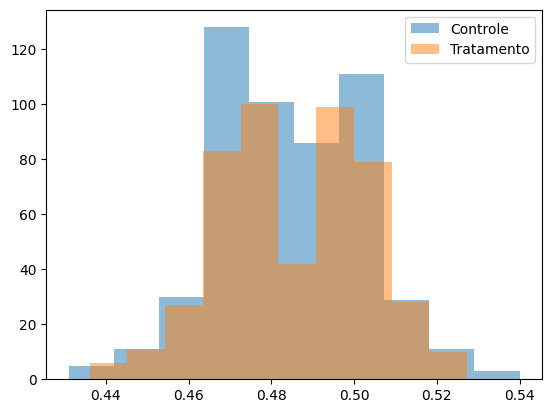

In [39]:
# Visualizando se temos unidades de controle e tratamento nas mesmas faixas do propensity score (Pressuposto da Positividade)
plt.hist(df_f[df_f['T'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df_f[df_f['T'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.legend()
plt.show()

## 3 - Ajustando os modelos do DoubleML

In [7]:
# Ajustando os modelos de XGBoost que serão usados

# Modelo que preve o Outcome (Y) com base nas confundidoras (X)
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")

# Modelo que preve o Tratamento (T) com base nas confundidoras (X)
boost_class = XGBClassifier(n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

In [8]:
# Inicializando o DoubleML
data_dml_base = dml.DoubleMLData(df,
                                 y_col='Y',
                                 d_cols='T',
                                 x_cols=features_base)

In [9]:
np.random.seed(42)
# Ajustando o DoubleML, definindo o numero de folds para o cross-fiting (n_folds) e número de repeticoes do processo (n_rep)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 10,
                                n_rep = 5)

In [10]:
# Hiperparametros que serao tunados de cada modelo de XGBoost (Y~X e T~X)
par_grids = {'ml_l': {'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1, 10]},
             'ml_m': {'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1, 10]}}

In [11]:
np.random.seed(42)
#tunando os modelos via random search
dml_plr_boost.tune(par_grids, search_mode='randomized_search', n_iter_randomized_search=500)

C:\Users\gcabr\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## 3 - Executando o DoubleML

In [12]:
# Rodando o modelo DoubleML utilizando os melhores hiperparametros encontrados
dml_plr_boost.fit(store_predictions=True)

# Mostrando o impacto de T em Y e seus respectivos intervalos de confianca (com Bootstrap ao final)
print(dml_plr_boost.summary)
print(dml_plr_boost)
bootstrap_results = dml_plr_boost.bootstrap(method='normal', n_rep_boot=500) # intervalo de confianca com Bootstrap
print("Bootstrap confidence intervals:\n", bootstrap_results.confint(joint=True))

       coef  std err          t         P>|t|     2.5 %    97.5 %
T  2.830378  0.18651  15.175515  5.137318e-52  2.464337  3.196419
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['T']
Covariates: ['X1', 'X2', 'X3_B']
Instrument variable(s): None
No. Observations: 1000

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_t